In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import dm_env

import wandb

import jax
import helx
from helx.rl import baselines

import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
env = helx.rl.environment.make_minigrid("MiniGrid-Empty-6x6-v0")
preprocess = jax.jit(helx.rl.environment.preprocess_minigrid, backend="cpu")
x = env.reset().observation

(56, 56, 3)


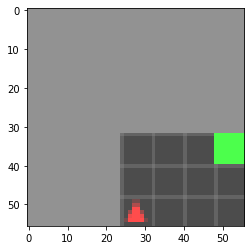

In [4]:
x = preprocess(env.step(2).observation)
print(x.shape)
plt.imshow(x)

In [5]:
hparams = baselines.dqn.HParams(replay_memory_size=5000, replay_start=5000, batch_size=32)
agent = baselines.dqn.Dqn((56, 56, 3), env.action_spec().num_values, hparams, preprocess=preprocess)

In [6]:
import wandb
wandb.init()
a = helx.rl.run.run(agent, env, 1000000)

wandb: Currently logged in as: epignatelli (use `wandb login --relogin` to force relogin)
/home/epignatelli/anaconda3/envs/rl/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


AttributeError: 'int' object has no attribute 'observation'

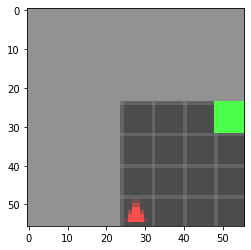

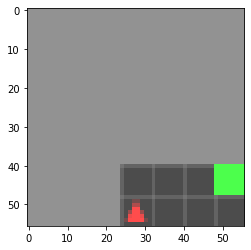

In [8]:
def ite(env):
    for i in range(10):
        t = env.step(i % 4)
    return env, t

t = env.reset()
plt.imshow(t.observation)
plt.show()

env, t = ite(env)
plt.imshow(t.observation)
plt.show()



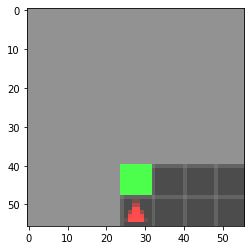

In [17]:
t = env.step(2)
plt.imshow(t.observation)
plt.show()